# Plot Utils Examples

In [1]:
%matplotlib inline
import dr_gen.analyze.plot_utils as pu
import random

%load_ext autoreload
%autoreload 2

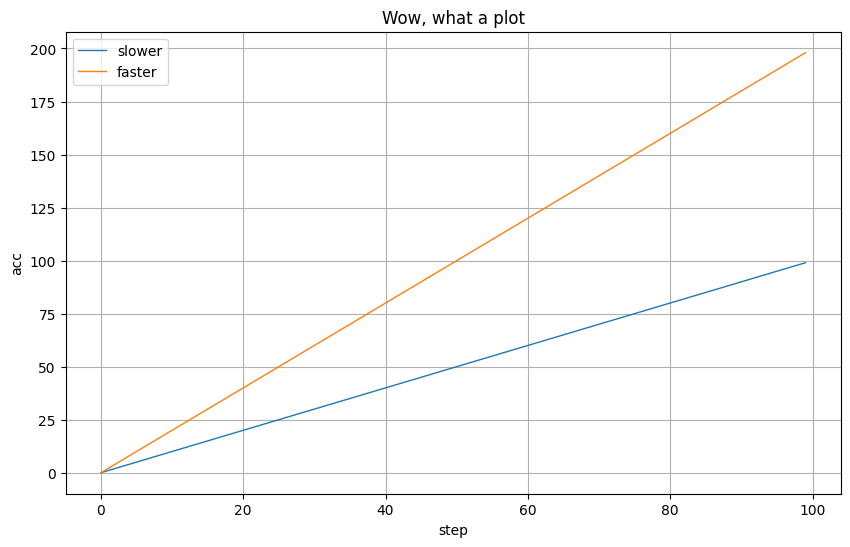

In [2]:
# Test: Make Line Plot
pu.make_line_plot(
    [list(range(100)), [i*2 for i in range(100)]],
    xs=list(range(100)),
    xlabel="step",
    ylabel="acc",
    title="Wow, what a plot",
    labels=["slower", "faster"],
)

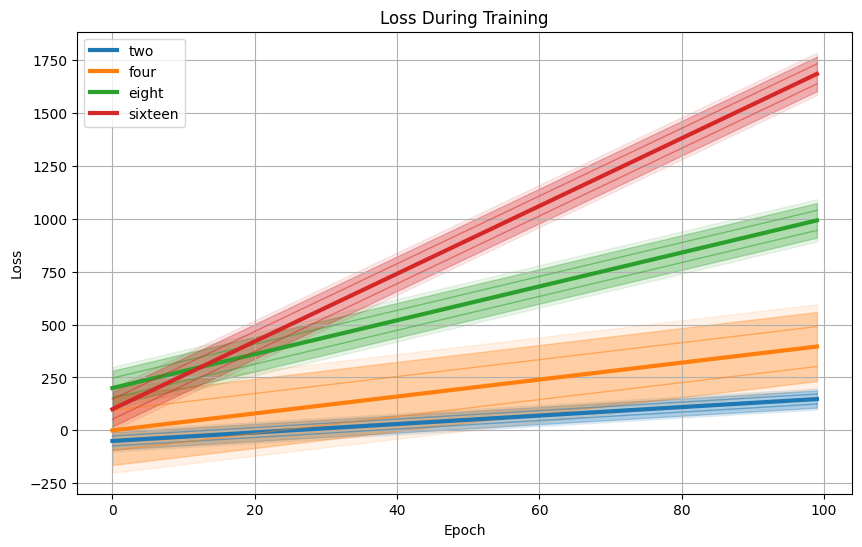

In [3]:
# Test: Make Summary Line Plot
pu.make_summary_line_plot(
    [
        [[i*2 - 100 for i in range(100)], [i*2 - 50 for i in range(100)], [i*2 for i in range(100)]], 
        [[i*4 - 200 for i in range(100)], [i*4 for i in range(100)], [i*4 + 200 for i in range(100)]], 
        [[i*8 + 100 for i in range(100)], [i*8 + 200 for i in range(100)], [i*8 + 300 for i in range(100)]], 
        [[i*16 for i in range(100)], [i*16 + 100 for i in range(100)], [i*16 + 200 for i in range(100)]], 
    ],
    labels=['two', 'four', 'eight', 'sixteen'],
)

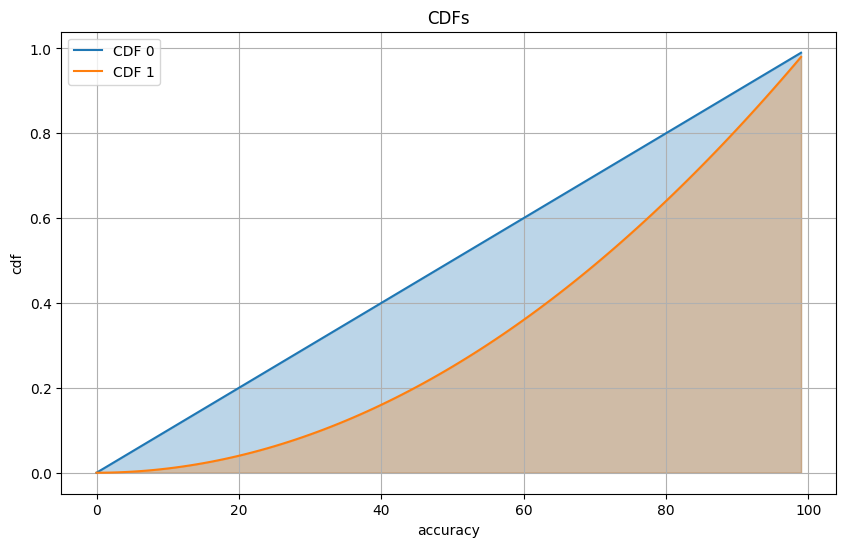

In [4]:
# Test: Make CDF Plot
pu.make_cdfs_plot(
    vals=list(range(100)),
    cdfs=[
        [i / 100.0 for i in range(100)],
        [i*i / (100.0 * 100.0) for i in range(100)],
    ],
)

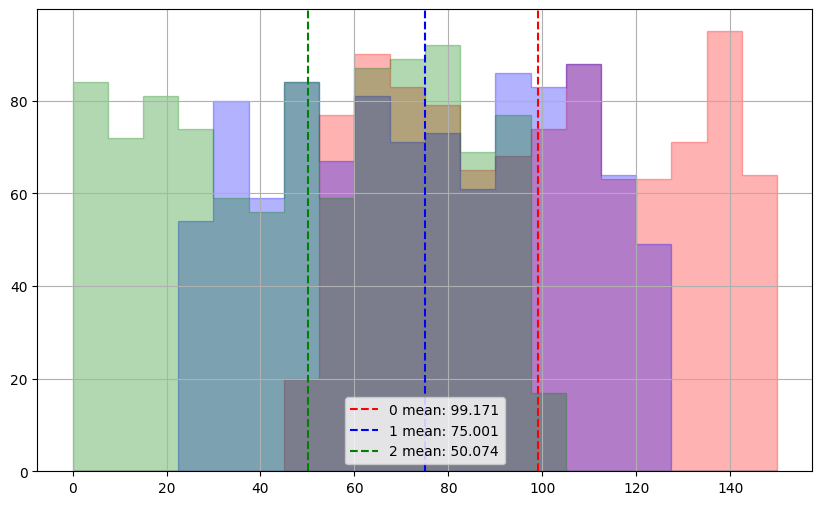

In [5]:
# Test: Make Histogram Plot
vals = [
    [rc + 50 for rc in random.choices(range(100), k=1000)],
    [rc + 25 for rc in random.choices(range(100), k=1000)],
    [rc for rc in random.choices(range(100), k=1000)],
]
means = [sum(v) / len(v) for v in vals]
pu.make_histogram_plot(
    vals,
    means=means,
    hist_range=(0,150),
    nbins=20,
    alpha=0.3,
    labels=[f"{i} mean: {means[i]}" for i in range(len(vals))],
)

# Plot Utils Iteration

In [70]:
%matplotlib inline

from hydra import initialize, compose
from omegaconf import OmegaConf 

import random

import dr_gen.utils.run as ru
import dr_gen.utils.display as dsp
import dr_gen.analyze.plot_utils as pu

from dr_gen.analyze.run_group import RunGroup
import dr_gen.analyze.result_plotting as rplt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup

In [2]:
with initialize(config_path="../configs/", version_base=None):
    cfg = compose(
        config_name="config.yaml",
        overrides=[
            "paths=mac",
        ]
    )

In [3]:
generator = ru.set_deterministic(cfg.seed)

In [4]:
rg = RunGroup()
rg.load_runs_from_base_dir(cfg.paths.agg_results)
rg.ignore_runs_by_hpms(epochs=180)
print(dsp.make_table(*rg.get_swept_table_data()))

>> 0 / 1288 files failed parsing
>> Updated hpm sweep info
>> Ignoring rid: 1287
>> Updated hpm sweep info
+------+------------+
| Key  |   Values   |
+------+------------+
| Init |   random   |
|      | pretrained |
+------+------------+
|  WD  |  0.00016   |
|      |   1e-05    |
|      |   4e-05    |
|      |   0.0001   |
|      |  6.3e-05   |
|      |  0.00025   |
+------+------------+
|  LR  |    0.16    |
|      |    0.06    |
|      |    0.04    |
|      |    0.01    |
|      |    0.2     |
|      |    0.25    |
|      |    0.1     |
+------+------------+


### Plot Testing

In [132]:
runs = rg.select_run_data_by_hpms(**{"optim.lr": 0.1, "optim.weight_decay": 1e-4})
for hpm, rlist in runs.items():
    print(f" - {str(hpm):70} | {len(rlist):,} RIDS")

 - model.weights=None optim.lr=0.1 optim.weight_decay=0.0001              | 99 RIDS
 - model.weights=DEFAULT optim.lr=0.1 optim.weight_decay=0.0001           | 103 RIDS


In [133]:
rdata_tuples = [(hpm, [rid for rid, _ in rlist], [rdata for _, rdata in rlist]) for hpm, rlist in runs.items()]

In [134]:
hpm, rids, rdatas = rdata_tuples[0]
split = "train"
#splits = ['train', 'val', 'eval']
splits = ['train', 'val']
run_ind = 0
metric_name = "acc1"
num_to_plot = 8

# Just for sanity checking
print(f">> {str(hpm)} | {split} | Run {run_ind} | {metric_name}")
train_data = rdatas[run_ind].get_split_metrics(split)
train_xs = train_data.get_xs()
train_acc = train_data.get_vals(metric_name)
print("X Vals:", train_xs[:5], "...")
print("Acc Vals:", train_acc[:5], "...")


>> model.weights=None optim.lr=0.1 optim.weight_decay=0.0001 | train | Run 0 | acc1
X Vals: [0, 1, 2, 3, 4] ...
Acc Vals: [27.242500400543214, 38.68000078201294, 43.54250087738037, 47.25250062942505, 52.687500619888304] ...


In [135]:
ds_1 = rdata_tuples[0]
ds_2 = rdata_tuples[1]

#### Example Seed Comparison Line Plot

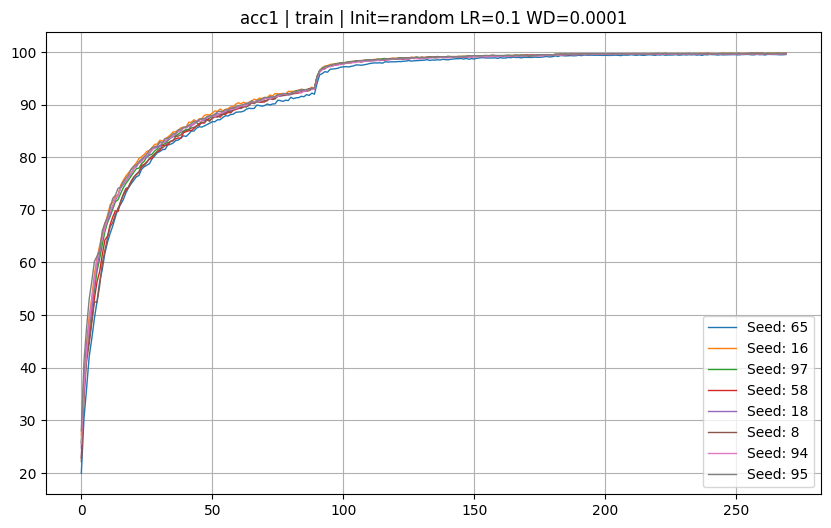

In [77]:
rds = random.sample(rdatas, num_to_plot)
pu.make_line_plot(
    [
        rd.get_split_metrics(split).get_vals(metric_name) for rd in rds
    ],
    title=f"{metric_name} | {split} | {rg.get_display_hpm_str(hpm)}",
    labels=[f"Seed: {rd.hpms._all_values['seed']}" for rd in rds],
)

#### Example Split Comparison Line Plot

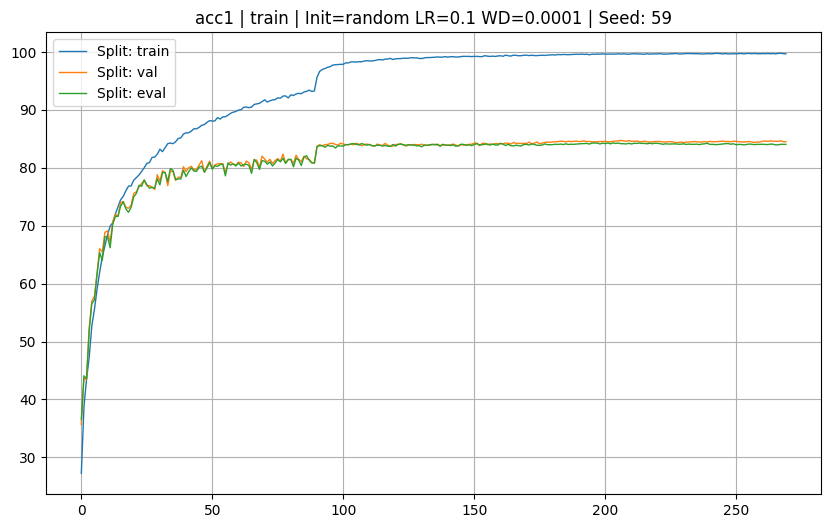

In [29]:
pu.make_line_plot(
    [
        rdatas[run_ind].get_split_metrics(split).get_vals(metric_name) for split in rdatas[run_ind].metrics_by_split.keys()
    ],
    title=f"{metric_name} | {split} | {rg.get_display_hpm_str(hpm)} | Seed: {rdatas[run_ind].hpms.get_from_all('seed')}",
    labels=[f"Split: {split}" for split in rdatas[run_ind].metrics_by_split.keys()],
)

#### Example: Comparing random samples from same hpms (lines)

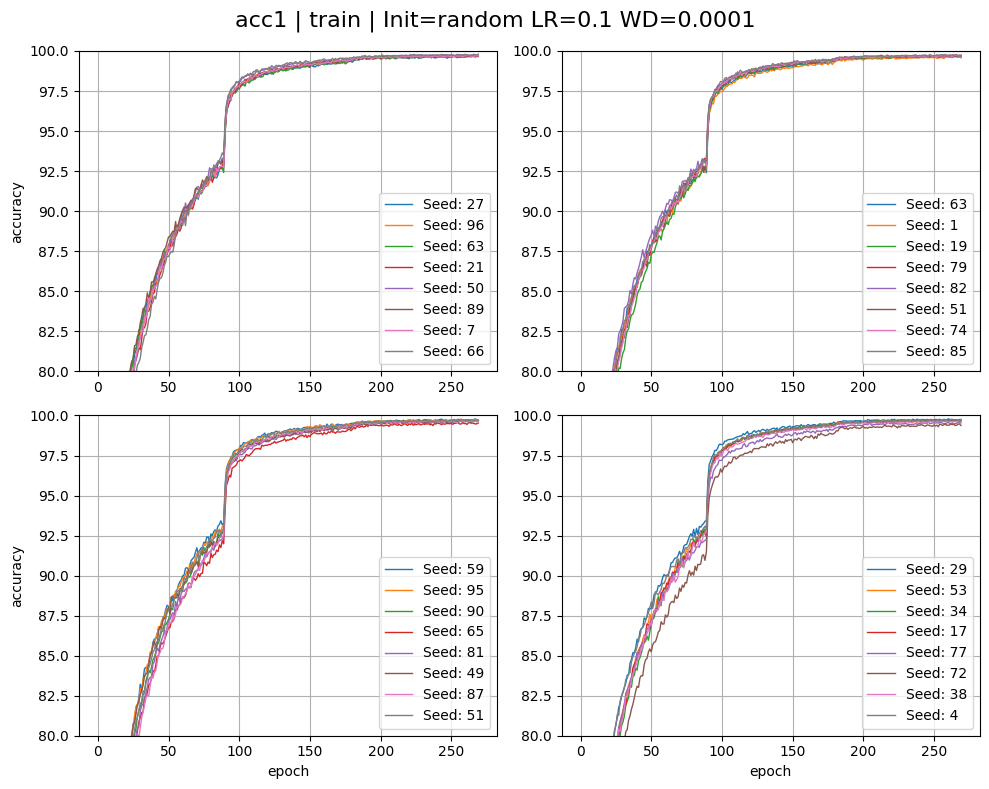

In [78]:
rd_lists = [random.sample(rdatas, num_to_plot) for i in range(4)]
pu.grid_wrapper(
    pu.make_line_plot, 
    [
        [
            rd.get_split_metrics(split).get_vals(metric_name) for rd in rds
        ] for rds in rd_lists
    ],
    figsize=(4,5),
    suptitle=f"{metric_name} | {split} | {rg.get_display_hpm_str(hpm)}",
    labels=[
        [
            f"Seed: {rd.hpms._all_values['seed']}" for rd in rds
        ] for rds in rd_lists
    ],
    subplot_xlabel="epoch",
    subplot_ylabel="accuracy",
    subplot_shape=(2,2),
    ylim=(80, 100),
)

#### Example: Comparing samples from two different hpms (lines)

(1, 2)


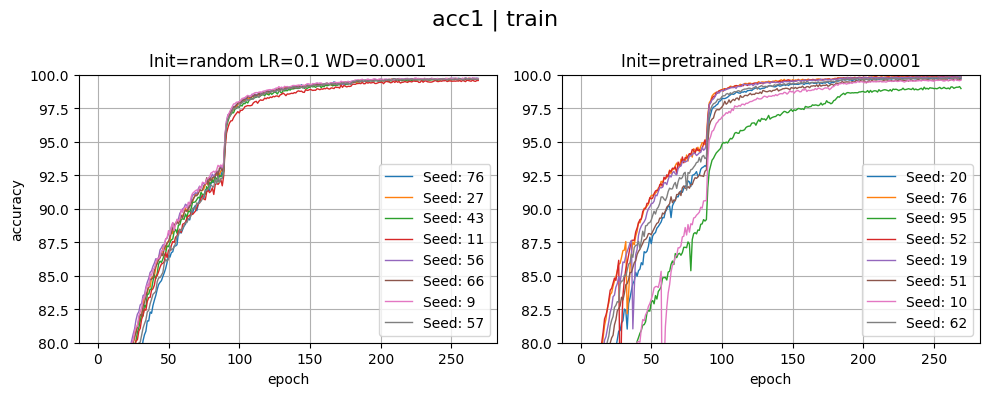

In [146]:
#hpm, _, rdatas = ds
ds_list = [ds_1, ds_2]
rd_inds = [random.sample(list(range(len(ds[-1]))), num_to_plot) for ds in ds_list]
pu.grid_wrapper(
    pu.make_line_plot, 
    [
        [
            rdatas[rd_i].get_split_metrics(split).get_vals(metric_name) for rd_i in rd_inds[ds_ind]
        ] for ds_ind, (_, _, rdatas) in enumerate(ds_list)
    ],
    figsize=(4,5),
    suptitle=f"{metric_name} | {split}",
    labels=[
        [
            f"Seed: {rd.hpms._all_values['seed']}" for rd in rds
        ] for rds in rd_lists
    ],
    title=[
        f"{rg.get_display_hpm_str(hpm)}" for hpm, _, _ in ds_list
    ],
    subplot_xlabel="epoch",
    subplot_ylabel="accuracy",
    ylim=(80, 100),
)

#### Example: Split Comparison, Seed Samples from Same Hpms, Line Plot Grid

(2, 2)
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


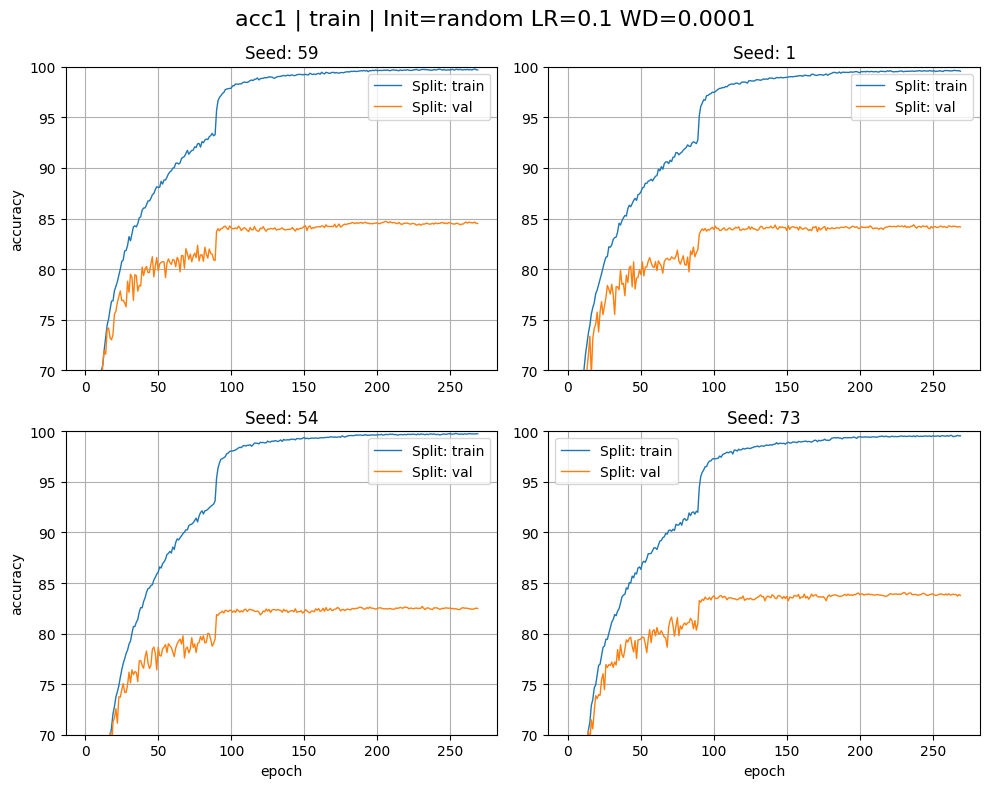

In [147]:
pu.grid_wrapper(
    pu.make_line_plot, 
    [
        [
            rd.get_split_metrics(split).get_vals(metric_name) for split in splits
        ] for rd in rdatas[:4]
    ],
    figsize=(4,5),
    suptitle=f"{metric_name} | {split} | {rg.get_display_hpm_str(hpm)}",
    subplot_xlabel="epoch",
    subplot_ylabel="accuracy",
    subplot_shape=(2,2),
    title=[f"Seed: {rd.hpms.get_from_all('seed')}" for rd in rdatas[:4]],
    labels=[
        [f"Split: {split}" for split in rd.metrics_by_split.keys()] for rd in rdatas[:4]
    ],
    ylim=(70,100),
)

#### Example: Split Comparison, Diff Hpms, Line Plot Grid

(1, 2)


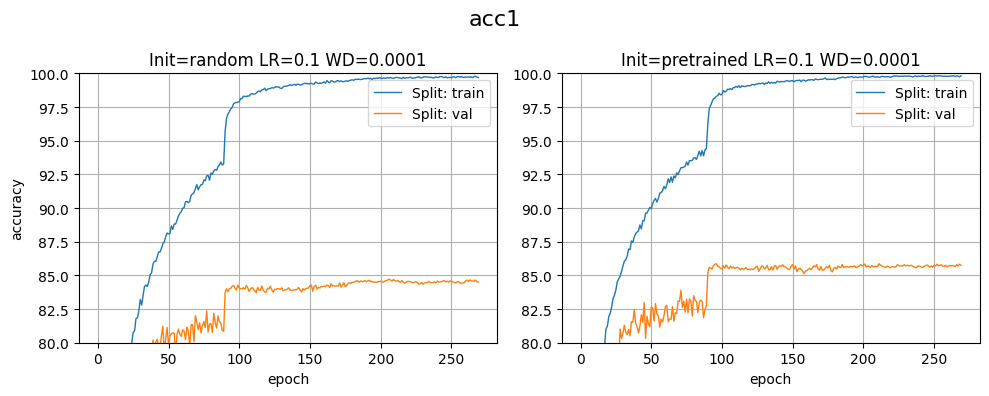

In [154]:
ds_list = [ds_1, ds_2]
pu.grid_wrapper(
    pu.make_line_plot, 
    [
        [
            rdatas[run_ind].get_split_metrics(split).get_vals(metric_name) for split in splits
        ] for ds_ind, (_, _, rdatas) in enumerate(ds_list)
    ],
    figsize=(4,5),
    suptitle=f"{metric_name}",
    subplot_xlabel="epoch",
    subplot_ylabel="accuracy",
    title=[f"{rg.get_display_hpm_str(hpm)}" for hpm, _, _ in ds_list],
    labels=[[f"Split: {split}" for split in splits] for _ in ds_list],
    ylim=(80,100),
)

#### Example: Run Split Summary Plot

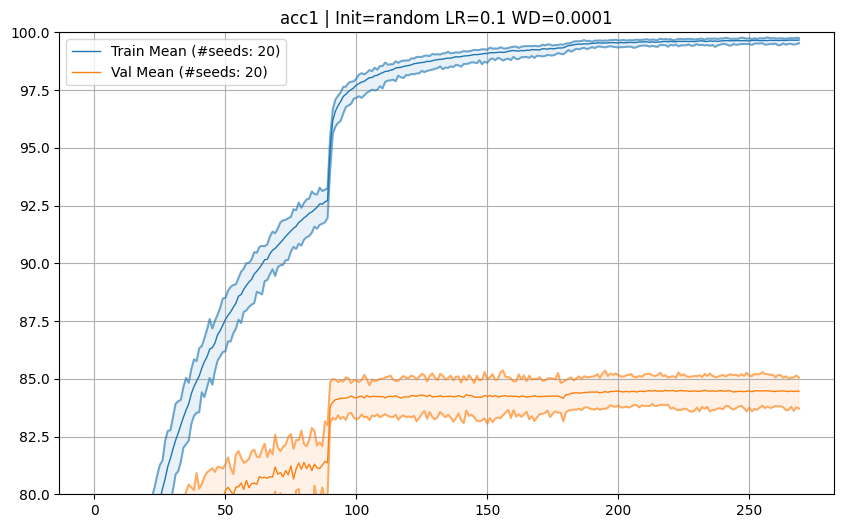

In [111]:
rds = random.sample(rdatas, num_to_plot)
pu.make_summary_plot(
    [
        [
            rd.get_split_metrics(split).get_vals(metric_name) for rd in rds
        ] for split in splits
    ],
    labels=[s[0].upper() + s[1:] for s in splits],
    ylim=(80,100),
    title=f"{metric_name} | {rg.get_display_hpm_str(hpm)}",
)

#### Example: Run Split Summary Plot Grid, Samples from Same Hpms

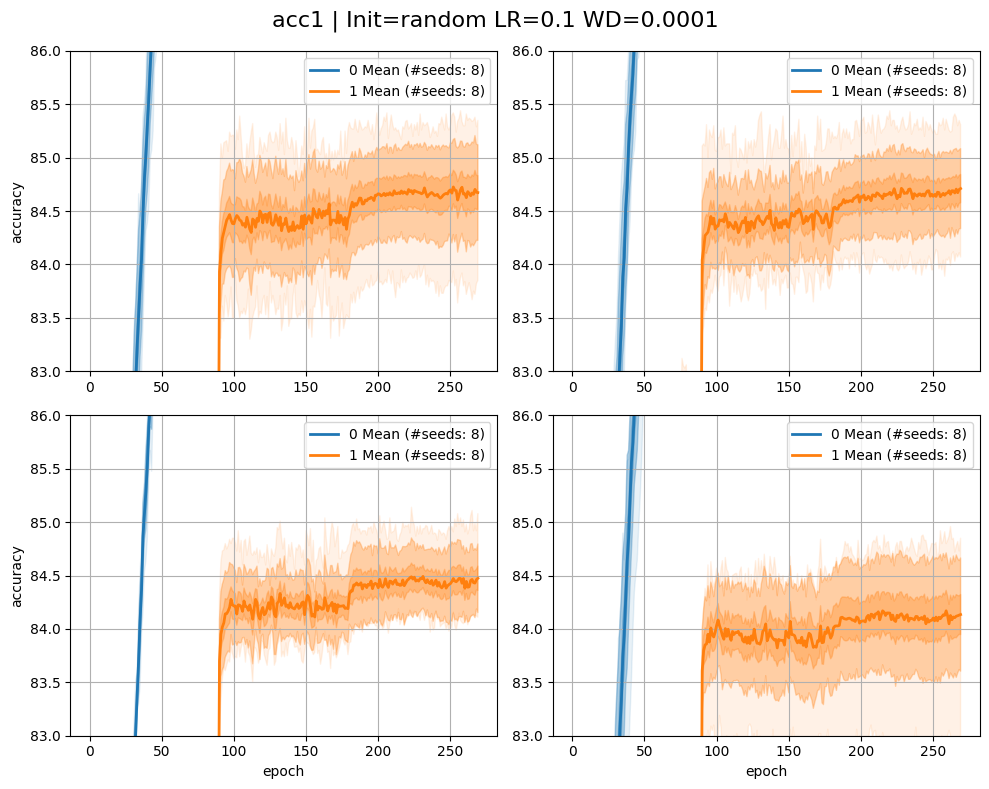

In [131]:
rd_lists = [random.sample(rdatas, num_to_plot) for graph_num in range(4)]
pu.grid_wrapper(
    pu.make_summary_plot, 
    [
        [
            [
                rd.get_split_metrics(split).get_vals(metric_name) for rd in rds
            ] for split in splits
        ] for rds in rd_lists
    ],
    figsize=(4,5),
    suptitle=f"{metric_name} | {rg.get_display_hpm_str(hpm)}",
    subplot_xlabel="epoch",
    subplot_ylabel="accuracy",
    subplot_shape=(2,2),
    #title=[f"Seed: {rd.hpms.get_from_all('seed')}" for rd in rdatas[:4]],
    #labels=[
    #    [f"Split: {split}" for split in rd.metrics_by_split.keys()] for rd in rdatas[:4]
    #],
    ylim=(83,86),
)

#### Example: Run Split Summary Plot Grid, Diff Hpms

(1, 2)


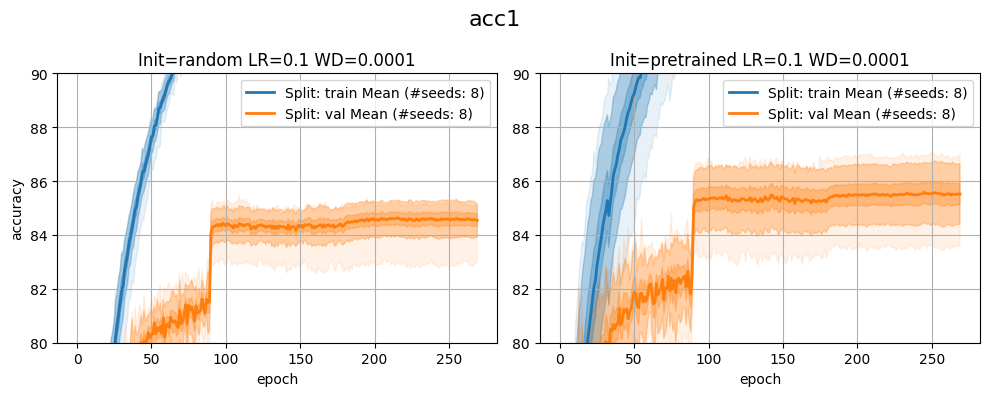

In [165]:
ds_list = [ds_1, ds_2]
rd_inds = [random.sample(list(range(len(rdatas))), num_to_plot) for _, _, rdatas in ds_list]
pu.grid_wrapper(
    pu.make_summary_plot, 
    [
        [
            [
                rdatas[rd_i].get_split_metrics(split).get_vals(metric_name) for rd_i in rd_inds[ds_ind]
            ] for split in splits
        ] for ds_ind, (_, _, rdatas) in enumerate(ds_list)
    ],
    figsize=(4,5),
    suptitle=f"{metric_name}",
    subplot_xlabel="epoch",
    subplot_ylabel="accuracy",
    title=[f"{rg.get_display_hpm_str(hpm)}" for hpm, _, _ in ds_list],
    labels=[[f"Split: {split}" for split in splits] for _ in ds_list],
    ylim=(80,90),
)

#### Example: Histograms

In [ ]:
# TBD

#### New Example